# This notebook does a quick comparison of sum-subtracted and Feynman-Hellman data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import gvar as gv
import h5py
import lsqfit
import h5data_methods as h5_dm

In [3]:
# Constants

#Physical constants
hbarc = 197.3 # MeV fm
a = 0.12

# Pion mass
mpi = 0.1885
#mpi = 0.2

# Plot constants
t_min_plt = 1
t_max_plt = 25

# Array of tsep values
tsep_vals = np.arange(3,13,1)
tsep_vals

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

### Load data

In [4]:
data = {}
data['2pt_dat'] = h5_dm.get_2pt("a12m310_a_avg.h5")
data['2pt_SS'] = data['2pt_dat'][:,:,0]
data['2pt_PS'] = data['2pt_dat'][:,:,1]
data['3pt_A3_unsymm'] = h5_dm.get_3pt("a12m310_a_avg.h5", "A3", 3, 13)
data['3pt_V4_unsymm'] = h5_dm.get_3pt("a12m310_a_avg.h5", "V4", 3, 13)
data['FH_N_A3'] = h5_dm.get_FH("a12m310_a_fh.h5", "gA")
data['FH_N_V4'] = h5_dm.get_FH("a12m310_a_fh.h5", "gV")
data['FH_N'] = h5_dm.get_FH("a12m310_a_fh.h5", "all")

In [6]:
gv_avg_data = gv.BufferDict()
gv_avg_data = gv.dataset.avg_data(data)

# Symmetrize the 3-point data
gv_avg_data['3pt_A3'] = np.array([ [ (gv_avg_data['3pt_A3_unsymm'][i][j] + gv_avg_data['3pt_A3_unsymm'][i][i + tsep_vals[0] - j])/2. for j in range(len(gv_avg_data['3pt_A3_unsymm'][i]))] for i in range(len(gv_avg_data['3pt_A3_unsymm']))]) 
gv_avg_data['3pt_V4'] = np.array([ [ (gv_avg_data['3pt_V4_unsymm'][i][j] + gv_avg_data['3pt_V4_unsymm'][i][i + tsep_vals[0] - j])/2. for j in range(len(gv_avg_data['3pt_V4_unsymm'][i]))] for i in range(len(gv_avg_data['3pt_V4_unsymm']))])


# Calculate the ratio between 3-point and 2-point data, for both A3 and V4
gv_avg_data['C_ratio_A3'] = np.array([ [gv_avg_data['3pt_A3'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_A3'] = np.array([np.sum(gv_avg_data['3pt_A3'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^sumsub_A3'] = np.array([ (gv_avg_data['Csum_A3'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_A3'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

gv_avg_data['C_ratio_V4'] = np.array([ [gv_avg_data['3pt_V4'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_V4'] = np.array([np.sum(gv_avg_data['3pt_V4'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^sumsub_V4'] = np.array([ (gv_avg_data['Csum_V4'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_V4'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])


# The 2-point effective masses and z-vals
gv_avg_data['2pt_meff'] = np.log(np.array([gv_avg_data['2pt_dat'][j,:]/gv_avg_data['2pt_dat'][j+1,:] for j in range(63)]))
gv_avg_data['2pt_SS_meff'] = np.log(np.array([gv_avg_data['2pt_SS'][j]/gv_avg_data['2pt_SS'][j+1] for j in range(63)]))
gv_avg_data['2pt_PS_meff'] = np.log(np.array([gv_avg_data['2pt_PS'][j]/gv_avg_data['2pt_PS'][j+1] for j in range(63)]))

gv_avg_data['2pt_zSeff'] = np.array([np.sqrt(np.exp(gv_avg_data['2pt_SS_meff'][t]*t)*gv_avg_data['2pt_SS'][t]) for t in range(63)])
gv_avg_data['2pt_zPeff'] = np.array([np.exp(gv_avg_data['2pt_PS_meff'][t]*t)*gv_avg_data['2pt_PS'][t]/gv_avg_data['2pt_zSeff'][t] for t in range(63)])

# Sum-subtract the Feynman-Hellman raw data to get a FH dataset
gv_avg_data['2pt_D'] = np.transpose(np.array([gv_avg_data['2pt_SS'], gv_avg_data['2pt_PS'], gv_avg_data['2pt_SS'], gv_avg_data['2pt_PS']]))
gv_avg_data['FH_dat'] = np.roll(gv_avg_data['FH_N']/gv_avg_data['2pt_D'], -1, axis = 0) - gv_avg_data['FH_N']/gv_avg_data['2pt_D']

# Create bounded datasents for fitting 
#gv_avg_data['2pt'] = np.array([[[gv_avg_data['2pt_dat'][i][0]], [gv_avg_data['2pt_dat'][i][1]]] for i in range(2, 13)])
#gv_avg_data['3pt_combined_tau1_2d'] = np.array([ [ [[gv_avg_data['3pt_A3'][i][j]], [gv_avg_data['3pt_V4'][i][j]]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
#gv_avg_data['3pt_combined_tau2_2d'] = np.array([ [ [[gv_avg_data['3pt_A3'][i][j]], [gv_avg_data['3pt_V4'][i][j]]] for j in range(2, i+2)] for i in range(1, len(tsep_vals))])
#gv_avg_data['3pt_combined_tau1_1d'] = convert_2dto1d(t_1d_array_tau1, t_2d_array_tau1, gv_avg_data['3pt_combined_tau1_2d'])
#gv_avg_data['3pt_combined_tau2_1d'] = convert_2dto1d(t_1d_array_tau2, t_2d_array_tau2, gv_avg_data['3pt_combined_tau2_2d'])
#gv_avg_data['C^sumsub_combined'] = np.transpose(np.append([gv_avg_data['C^sumsub_A3'],], [gv_avg_data['C^sumsub_V4'],], axis = 0))
#gv_avg_data['FH'] = gv_avg_data['FH_dat'][2:13] #np.array([[gv_avg_data['FH_dat'][i][0], gv_avg_data['FH_dat'][i][1], gv_avg_data['FH_dat'][i][2], gv_avg_data['FH_dat'][i][3]] for i in range(2, tsep_vals[:-1])])

#gv_avg_data[]

<ipython-input-6-240d130a6f21>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gv_avg_data['C_ratio_A3'] = np.array([ [gv_avg_data['3pt_A3'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
<ipython-input-6-240d130a6f21>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gv_avg_data['C_ratio_V4'] = np.array([ [gv_avg_data['3pt_V4'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
<ipython-input-6-240d130a6f21>:20: RuntimeWarning: invalid value encou

## Plot sumsub vs FH data

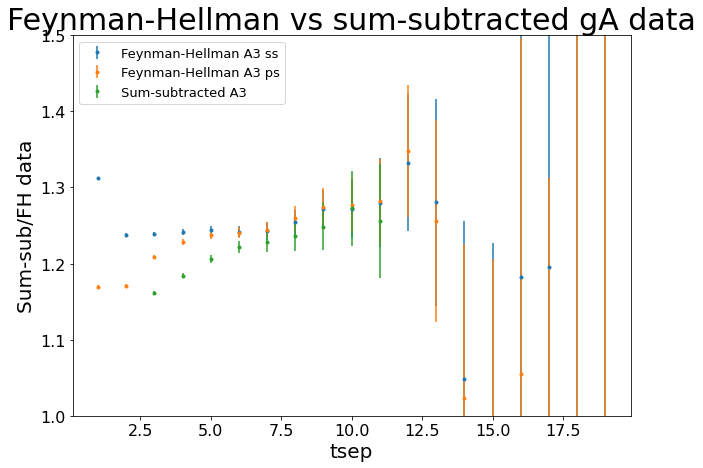

In [13]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes()
ax.errorbar(np.array([i for i in range(1,20)]), np.array([gv_avg_data['FH_dat'][i][0].mean for i in range(1, 20)]), yerr=np.array([gv_avg_data['FH_dat'][i][0].sdev for i in range(1, 20)]), fmt='.', label="Feynman-Hellman A3 ss")
ax.errorbar(np.array([i for i in range(1,20)]), np.array([gv_avg_data['FH_dat'][i][1].mean for i in range(1, 20)]), yerr=np.array([gv_avg_data['FH_dat'][i][1].sdev for i in range(1, 20)]), fmt='.', label="Feynman-Hellman A3 ps")
ax.errorbar(np.array([i for i in range(3,12)]), np.array([gv_avg_data['C^sumsub_A3'][i].mean for i in range(len(range(3, 12)))]), yerr=np.array([gv_avg_data['C^sumsub_A3'][i].sdev for i in range(len(range(3, 12)))]), fmt='.', label="Sum-subtracted A3")

plt.title("Feynman-Hellman vs sum-subtracted gA data", fontsize=30)
plt.xlabel("tsep", fontsize=20)
plt.ylabel("Sum-sub/FH data", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(1.0, 1.5)

plt.legend(fontsize = 13)
plt.show()



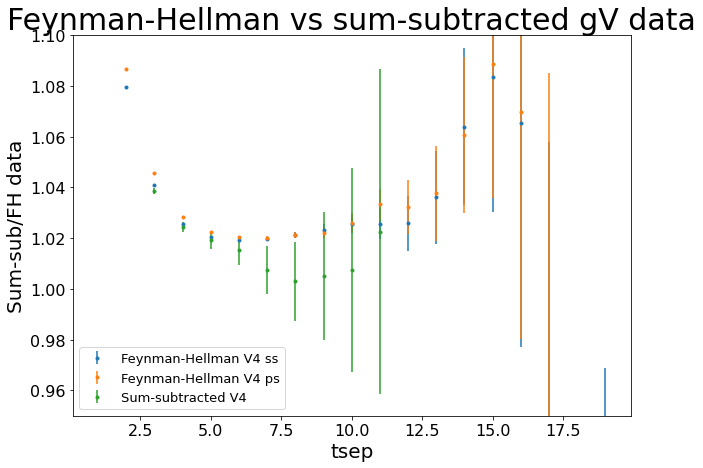

In [15]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes()
ax.errorbar(np.array([i for i in range(1,20)]), np.array([gv_avg_data['FH_dat'][i][2].mean for i in range(1, 20)]), yerr=np.array([gv_avg_data['FH_dat'][i][2].sdev for i in range(1, 20)]), fmt='.', label="Feynman-Hellman V4 ss")
ax.errorbar(np.array([i for i in range(1,20)]), np.array([gv_avg_data['FH_dat'][i][3].mean for i in range(1, 20)]), yerr=np.array([gv_avg_data['FH_dat'][i][3].sdev for i in range(1, 20)]), fmt='.', label="Feynman-Hellman V4 ps")
ax.errorbar(np.array([i for i in range(3,12)]), np.array([gv_avg_data['C^sumsub_V4'][i].mean for i in range(len(range(3, 12)))]), yerr=np.array([gv_avg_data['C^sumsub_V4'][i].sdev for i in range(len(range(3, 12)))]), fmt='.', label="Sum-subtracted V4")

plt.title("Feynman-Hellman vs sum-subtracted gV data", fontsize=30)
plt.xlabel("tsep", fontsize=20)
plt.ylabel("Sum-sub/FH data", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0.95, 1.1)

plt.legend(fontsize = 13)
plt.show()

